In [405]:
import pandas as pd
import numpy as np
from pybaseball import statcast
from pybaseball import pitching_stats
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [286]:
"""
data20_22 = statcast(start_dt = "2020-04-01", end_dt = "2022-12-01") 
data20_22.to_csv('Statcast_2020_to_2022.csv')
data23 = statcast(start_dt = "2023-04-01", end_dt = "2023-12-01")
data23.to_csv('Statcast_2023.csv')
"""

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates


100%|██████████| 589/589 [02:22<00:00,  4.15it/s]
/Users/maxwassarman/miniconda3/envs/baseball/lib/python3.12/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


This is a large query, it may take a moment to complete
Skipping offseason dates


 15%|█▌        | 35/229 [00:08<00:34,  5.58it/s]/Users/maxwassarman/miniconda3/envs/baseball/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
100%|██████████| 229/229 [00:55<00:00,  4.11it/s]
/Users/maxwassarman/miniconda3/envs/baseball/lib/python3.12/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


In [344]:
#Read in data
data20_22 = pd.read_csv("Statcast_2020_to_2022.csv")
data23 = pd.read_csv("Statcast_2023.csv")

In [345]:
#Select columns
data20_22 = data20_22[['player_name','pitch_type','release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','vz0','ax','ay','az','game_year','delta_run_exp']]
data23 = data23[['player_name','pitch_type','release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','vz0','ax','ay','az','game_year','delta_run_exp']]

In [346]:
#Drop na values
data20_22 = data20_22.dropna()
data23 = data23.dropna()

In [347]:
#Flip to get view from pitcher
data20_22['pfx_x'] = data20_22['pfx_x'] * -1
data23['pfx_x'] = data23['pfx_x'] * -1

#Change to inches
data20_22['pfx_x'] = data20_22['pfx_x'] * 12
data20_22['pfx_z'] = data20_22['pfx_z'] * 12
data23['pfx_x'] = data23['pfx_x'] * 12
data23['pfx_z'] = data23['pfx_z'] * 12

In [348]:
#caculate vaa and haa
def approach_angles(df):
    yf = 17/12
    y0 = 50
    df['vy_f'] = -np.sqrt(df['vy0']**2 - (2 * df['ay'] * y0 - yf))
    df['t'] = (df['vy_f'] - df['vy0']) / df['ay']
    df['vz_f'] = df['vz0'] + (df['az'] * df['t'])
    df['vx_f'] = df['vx0'] + (df['ax'] * df['t'])

    df['vaa'] = -np.arctan(df['vz_f'] / df['vy_f']) * (180 / np.pi)
    df['haa'] = -np.arctan(df['vx_f'] / df['vy_f']) * (180 / np.pi)
    return df

data20_22 = approach_angles(data20_22)
data23 = approach_angles(data23)

In [349]:
#caculate estimated axis differential and estimated spin efficiency
def axis_differential(df):
    df['inferred_spin_degree'] = np.arctan2(df['pfx_x'],df['pfx_z']) * (180 / np.pi)
    df['axis_dif'] = np.abs(df['inferred_spin_degree'] - df['spin_axis'])
    return df

def movmnt_difference(df):
    df['vert_dif'] = np.abs(df['az'] - df['pfx_z'])
    df['horz_dif'] = np.abs(df['ax'] - df['pfx_x'])
    return df

data20_22 = axis_differential(data20_22)
data23 = axis_differential(data23)

data20_22 = movmnt_difference(data20_22)
data23 = movmnt_difference(data23)


In [350]:
#Remove unnecessary pitches
data20_22 = data20_22[data20_22.pitch_type != 'PO']
data23 = data23[data23.pitch_type != 'PO']

In [351]:
#Retag pitches
data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FF','FA'], 'Fastball')
data23['pitch_type'] = data23['pitch_type'].replace(['FF','FA'], 'Fastball')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['SI'], 'Sinker')
data23['pitch_type'] = data23['pitch_type'].replace(['SI'], 'Sinker')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FC'], 'Cutter')
data23['pitch_type'] = data23['pitch_type'].replace(['FC'], 'Cutter')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['SL'], 'Slider')
data23['pitch_type'] = data23['pitch_type'].replace(['SL'], 'Slider')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['ST'], 'Sweeper')
data23['pitch_type'] = data23['pitch_type'].replace(['ST'], 'Sweeper')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['CU','CS','SV','KC'], 'Curveball')
data23['pitch_type'] = data23['pitch_type'].replace(['CU','CS','SV','KC'], 'Curveball')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['CH','FO','EP','KN','SC'], 'Changeup')
data23['pitch_type'] = data23['pitch_type'].replace(['CH','FO','EP','KN','SC'], 'Changeup')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FS'], 'Splitter')
data23['pitch_type'] = data23['pitch_type'].replace(['FS'], 'Splitter')



In [352]:
#Seperate pitches for different models
fastball_20_22 = data20_22[data20_22.pitch_type.isin(['Fastball'])]
fastball_23 = data23[data23.pitch_type.isin(['Fastball'])]

sinker_20_22 = data20_22[data20_22.pitch_type.isin(['Sinker'])]
sinker_23 = data23[data23.pitch_type.isin(['Sinker'])]

cutter_20_22 = data20_22[data20_22.pitch_type.isin(['Cutter'])]
cutter_23 = data23[data23.pitch_type.isin(['Cutter'])]

slider_20_22 = data20_22[data20_22.pitch_type.isin(['Slider'])]
slider_23 = data23[data23.pitch_type.isin(['Slider'])]

sweeper_20_22 = data20_22[data20_22.pitch_type.isin(['Sweeper'])]
sweeper_23 = data23[data23.pitch_type.isin(['Sweeper'])]

curveball_20_22 = data20_22[data20_22.pitch_type.isin(['Curveball'])]
curveball_23 = data23[data23.pitch_type.isin(['Curveball'])]

changeup_20_22 = data20_22[data20_22.pitch_type.isin(['Changeup'])]
changeup_23 = data23[data23.pitch_type.isin(['Changeup'])]

splitter_20_22 = data20_22[data20_22.pitch_type.isin(['Splitter'])]
splitter_23 = data23[data23.pitch_type.isin(['Splitter'])]


In [396]:
fastball_features_old = ['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']
fastball_features = ['release_speed','release_pos_x','release_pos_z','release_extension','pfx_x', 'pfx_z','game_year', 'vaa', 'haa', 'axis_dif', 'vert_dif', 'horz_dif']

In [397]:
#Split into train and test

fastball_x = fastball_20_22[fastball_features]
fastball_y = fastball_20_22['delta_run_exp']

x_train_fastball, x_test_fastball, y_train_fastball, y_test_fastball = train_test_split(fastball_x, fastball_y, train_size = 0.75, random_state = 12345)

sinker_x = sinker_20_22[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']]
sinker_y = sinker_20_22['delta_run_exp']

x_train_sinker, x_test_sinker, y_train_sinker, y_test_sinker = train_test_split(sinker_x, sinker_y, train_size=0.75, random_state=12345)

cutter_x = cutter_20_22[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']]
cutter_y = cutter_20_22['delta_run_exp']

x_train_cutter, x_test_cutter, y_train_cutter, y_test_cutter = train_test_split(cutter_x, cutter_y, train_size=0.75, random_state=12345)

slider_x = slider_20_22[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']]
slider_y = slider_20_22['delta_run_exp']

x_train_slider, x_test_slider, y_train_slider, y_test_slider = train_test_split(slider_x, slider_y, train_size=0.75, random_state=12345)

sweeper_x = sweeper_20_22[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']]
sweeper_y = sweeper_20_22['delta_run_exp']

x_train_sweeper, x_test_sweeper, y_train_sweeper, y_test_sweeper = train_test_split(sweeper_x, sweeper_y, train_size=0.75, random_state=12345)

curveball_x = curveball_20_22[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']]
curveball_y = curveball_20_22['delta_run_exp']

x_train_curveball, x_test_curveball, y_train_curveball, y_test_curveball = train_test_split(curveball_x, curveball_y, train_size=0.75, random_state=12345)

changeup_x = changeup_20_22[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']]
changeup_y = changeup_20_22['delta_run_exp']

x_train_changeup, x_test_changeup, y_train_changeup, y_test_changeup = train_test_split(changeup_x, changeup_y, train_size=0.75, random_state=12345)

splitter_x = splitter_20_22[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']]
splitter_y = splitter_20_22['delta_run_exp']

x_train_splitter, x_test_splitter, y_train_splitter, y_test_splitter = train_test_split(splitter_x, splitter_y, train_size=0.75, random_state=12345)

In [406]:
#Set params for catboost models
params = {
    'iterations': 100,
    'depth': 5,
    'learning_rate': 0.01,
    'random_seed': 12345
    
}


In [407]:
#Train each model

#Fastball
fastball_model = CatBoostRegressor(**params)
fastball_model.fit(x_train_fastball, y_train_fastball)

#Sinker
sinker_model = CatBoostRegressor(**params)
sinker_model.fit(x_train_sinker, y_train_sinker)

#Cutter
cutter_model = CatBoostRegressor(**params)
cutter_model.fit(x_train_cutter, y_train_cutter)

#Slider
slider_model = CatBoostRegressor(**params)
slider_model.fit(x_train_slider, y_train_slider)

#Sweeper
sweeper_model = CatBoostRegressor(**params)
sweeper_model.fit(x_train_sweeper, y_train_sweeper)

#Curveball
curveball_model = CatBoostRegressor(**params)
curveball_model.fit(x_train_curveball, y_train_curveball)

#Changeup
changeup_model = CatBoostRegressor(**params)
changeup_model.fit(x_train_changeup, y_train_changeup)

#Splitter
splitter_model = CatBoostRegressor(**params)
splitter_model.fit(x_train_splitter, y_train_splitter)



XGBRegressor(alpha=0.05, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.5, learning_rate=0.01,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None, ...)

In [408]:
#Predictions
fastball_23['pred'] = fastball_model.predict(fastball_23[fastball_features])

sinker_23['pred'] = sinker_model.predict(sinker_23[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']])

cutter_23['pred'] = cutter_model.predict(cutter_23[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']])

slider_23['pred'] = slider_model.predict(slider_23[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']])

sweeper_23['pred'] = sweeper_model.predict(sweeper_23[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']])

curveball_23['pred'] = curveball_model.predict(curveball_23[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']])

changeup_23['pred'] = changeup_model.predict(changeup_23[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']])

splitter_23['pred'] = splitter_model.predict(splitter_23[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']])

/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_56382/1987039132.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastball_23['pred'] = fastball_model.predict(fastball_23[fastball_features])
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_56382/1987039132.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sinker_23['pred'] = sinker_model.predict(sinker_23[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0

In [409]:
def scale_and_score(df):
    df['scaled'] = df['pred'] - df['pred'].max()
    df['scaled'] = abs(df['scaled'])
    df['scaled'] = df['scaled'] - df['scaled'].mean()
    df['scaled'] = df['scaled'] / df['scaled'].std()
    df['score'] = df['scaled'] * 10 + 100
    return df

In [410]:
scale_and_score(fastball_23)
scale_and_score(sinker_23)
scale_and_score(cutter_23)
scale_and_score(slider_23)
scale_and_score(sweeper_23)
scale_and_score(curveball_23)
scale_and_score(changeup_23)
scale_and_score(splitter_23)

/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_56382/625622879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scaled'] = df['pred'] - df['pred'].max()
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_56382/625622879.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scaled'] = abs(df['scaled'])
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_56382/625622879.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

,player_name,pitch_type,release_speed,release_pos_x,release_pos_z,release_spin_rate,release_extension,spin_axis,pfx_x,pfx_z,...,vx_f,vaa,haa,inferred_spin_degree,axis_dif,vert_dif,horz_dif,pred,scaled,score
106,"Eovaldi, Nathan",Splitter,87.3,-2.61,5.49,1498.0,6.7,240.0,10.32,1.32,...,2.839744,-8.424825,1.396455,82.711048,157.288952,31.551723,21.119094,-0.008229,0.407467,104.074669
107,"Eovaldi, Nathan",Splitter,88.6,-2.39,5.61,1638.0,6.7,237.0,11.04,2.88,...,3.414107,-7.982580,1.653563,75.379126,161.620874,31.567547,23.027677,-0.011091,0.610450,106.104492
108,"Eovaldi, Nathan",Splitter,85.6,-2.38,5.64,1574.0,6.7,241.0,12.00,2.04,...,3.183097,-9.072173,1.594330,80.351955,160.648045,31.427518,23.965423,-0.011688,0.652757,106.527573
109,"Eovaldi, Nathan",Splitter,88.5,-2.51,5.51,1634.0,6.7,236.0,12.96,1.56,...,2.593117,-8.388967,1.252717,83.136308,152.863692,31.346623,26.587585,-0.011471,0.637416,106.374161
112,"Eovaldi, Nathan",Splitter,88.0,-2.52,5.55,1492.0,6.5,242.0,13.56,1.80,...,2.391933,-7.970726,1.160314,82.438572,159.561428,31.609178,27.616537,-0.011471,0.637416,106.374161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723683,"Gilbert, Logan",Splitter,84.5,-1.34,6.04,1055.0,7.5,232.0,11.16,3.48,...,0.446863,-8.706240,0.224707,72.681062,159.318938,31.877064,21.467008,-0.008649,0.437241,104.372414
723685,"Gilbert, Logan",Splitter,86.0,-1.39,6.02,754.0,7.4,242.0,10.44,6.00,...,-1.497835,-7.285854,-0.732479,60.113473,181.886527,32.313911,20.185464,-0.004034,0.109944,101.099434
723686,"Gilbert, Logan",Splitter,85.8,-1.37,6.17,1055.0,7.3,225.0,14.76,1.92,...,-2.311453,-8.360472,-1.142360,82.588507,142.411493,31.716000,28.411911,-0.010123,0.541768,105.417686
723719,"Gilbert, Logan",Splitter,87.3,-1.30,6.08,1219.0,7.6,222.0,10.68,2.76,...,-0.952698,-9.388369,-0.462546,75.510237,146.489763,31.207524,21.011395,-0.009441,0.493424,104.934235


In [411]:
def calculate_mean_scores(df):
    mean_scores = df.groupby('player_name')['score'].mean().reset_index()
    mean_scores.rename(columns={'score': 'mean_scores'}, inplace=True)
    mean_scores = mean_scores.sort_values(by='mean_scores', ascending=False)
    mean_scores['mean_scores'] = mean_scores['mean_scores'].round(2)
    return mean_scores

mean_scores_fastball = calculate_mean_scores(fastball_23)
mean_scores_sinker = calculate_mean_scores(sinker_23)
mean_scores_cutter = calculate_mean_scores(cutter_23)
mean_scores_slider = calculate_mean_scores(slider_23)
mean_scores_sweeper = calculate_mean_scores(sweeper_23)
mean_scores_curveball = calculate_mean_scores(curveball_23)
mean_scores_changeup = calculate_mean_scores(changeup_23)
mean_scores_splitter = calculate_mean_scores(splitter_23)

combined_scores = mean_scores_fastball
combined_scores = combined_scores.merge(mean_scores_sinker, how = 'left', on = 'player_name', suffixes=('','_sinker'))
combined_scores = combined_scores.merge(mean_scores_cutter, how = 'left', on = 'player_name', suffixes=('','_cutter'))
combined_scores = combined_scores.merge(mean_scores_slider, how = 'left', on = 'player_name', suffixes=('','_slider'))
combined_scores = combined_scores.merge(mean_scores_sweeper, how = 'left', on = 'player_name', suffixes=('','_sweeper'))
combined_scores = combined_scores.merge(mean_scores_curveball, how = 'left', on = 'player_name', suffixes=('','_curveball'))
combined_scores = combined_scores.merge(mean_scores_changeup, how = 'left', on = 'player_name', suffixes=('','_changeup'))
combined_scores = combined_scores.merge(mean_scores_splitter, how = 'left', on = 'player_name', suffixes=('','_splitter'))



combined_scores = combined_scores.rename(columns = {
    'mean_scores': 'fastball',
    'mean_scores_sinker': 'sinker',
    'mean_scores_cutter': 'cutter',
    'mean_scores_slider': 'slider',
    'mean_scores_sweeper': 'sweeper',
    'mean_scores_curveball': 'curveball',
    'mean_scores_changeup': 'changeup',
    'mean_scores_splitter': 'splitter'
    }
)

In [412]:
pitch_counts = data23.groupby(['player_name', 'pitch_type']).size().unstack(fill_value=0).reset_index()

combined_data = combined_scores.merge(pitch_counts, how='left', on='player_name')
combined_data.fillna(0, inplace=True)

combined_data['weighted_fastball'] = combined_data['fastball'] * combined_data['Fastball']
combined_data['weighted_sinker'] = combined_data['sinker'] * combined_data['Sinker']
combined_data['weighted_cutter'] = combined_data['cutter'] * combined_data['Cutter']
combined_data['weighted_slider'] = combined_data['slider'] * combined_data['Slider']
combined_data['weighted_sweeper'] = combined_data['sweeper'] * combined_data['Sweeper']
combined_data['weighted_curveball'] = combined_data['curveball'] * combined_data['Curveball']
combined_data['weighted_changeup'] = combined_data['changeup'] * combined_data['Changeup']
combined_data['weighted_splitter'] = combined_data['splitter'] * combined_data['Splitter']

combined_data['total_weighted_score'] = (
    combined_data['weighted_fastball'] +
    combined_data['weighted_sinker'] +
    combined_data['weighted_cutter'] +
    combined_data['weighted_slider'] +
    combined_data['weighted_sweeper'] +
    combined_data['weighted_curveball'] +
    combined_data['weighted_changeup'] +
    combined_data['weighted_splitter']
)

combined_data['total_pitches'] = (
    combined_data['Fastball'] +
    combined_data['Sinker'] +
    combined_data['Cutter'] +
    combined_data['Slider'] +
    combined_data['Sweeper'] +
    combined_data['Curveball'] +
    combined_data['Changeup'] +
    combined_data['Splitter']
)

combined_data['overall'] = combined_data['total_weighted_score'] / combined_data['total_pitches']

combined_data['overall'] = combined_data['overall'].round(2)

combined_data = combined_data[['player_name', 'overall', 'fastball', 'sinker', 'cutter', 'slider', 'sweeper', 'curveball', 'changeup', 'splitter']]

combined_data = combined_data.sort_values(by='overall', ascending=False)

combined_data.to_csv("pitch_scores.csv", index=False)
combined_data

,player_name,overall,fastball,sinker,cutter,slider,sweeper,curveball,changeup,splitter
723,"Clase, Emmanuel",106.62,92.239998,0.000000,105.570000,109.019997,0.0,0.000000,0.000000,0.0
695,"Loáisiga, Jonathan",106.24,94.779999,108.519997,0.000000,0.000000,0.0,103.129997,101.680000,0.0
243,"Pressly, Ryan",106.12,100.559998,93.970001,105.250000,106.900002,0.0,111.559998,100.949997,0.0
78,"May, Dustin",106.00,102.910004,107.589996,103.760002,0.000000,0.0,110.349998,95.680000,0.0
151,"Uribe, Abner",105.66,101.669998,104.180000,0.000000,109.199997,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
776,"Alberto, Hanser",74.72,74.720001,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
777,"Lester, Josh",74.69,74.690002,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
778,"Kelly, Carson",73.25,73.250000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
782,"Zavala, Seby",70.05,70.050003,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [413]:
stat23 = pitching_stats(2023)

stat23 = stat23[['Name','FIP']]

def reformat_name(name):
    parts = name.split()
    first, last = parts
    return f"{last}, {first}"

stat23['Name'] = stat23['Name'].apply(reformat_name)

stat23 = stat23.rename(columns={
    'Name': 'player_name'
})

joined_data = stat23.merge(combined_data,how='left',on='player_name')
joined_data.dropna()

correlation = joined_data['FIP'].corr(joined_data['fastball'])
correlation

-0.12490496467456078

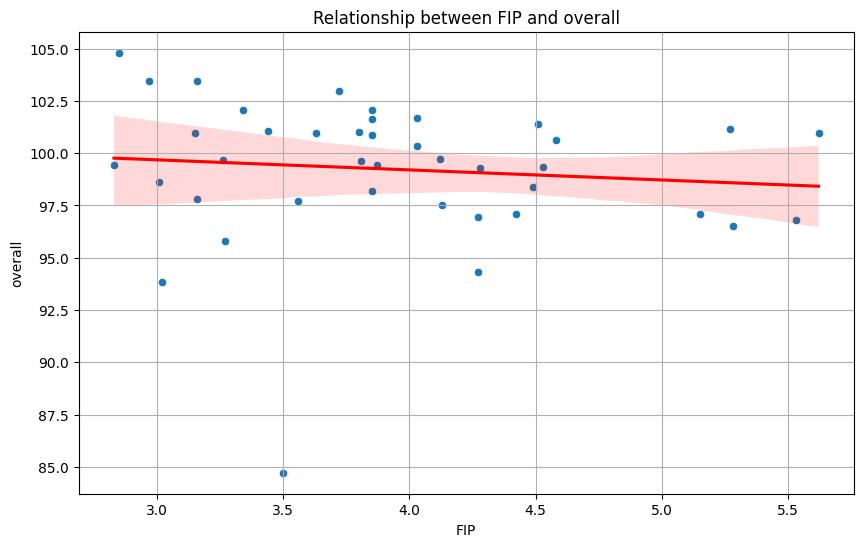

In [395]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='FIP', y='fastball', data=joined_data)
sns.regplot(x='FIP', y='fastball', data=joined_data, scatter=False, color='red')
plt.title(f'Relationship between FIP and overall')
plt.xlabel('FIP')
plt.ylabel('overall')
plt.grid(True)
plt.show()

In [ ]:
def plot_feature_importances(model, feature_names, title):
    feature_importances = model.get_feature_importance()
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

feature_cols = ['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']


plot_feature_importances(fastball_model, feature_cols, 'Fastball Feature Importances')
plot_feature_importances(sinker_model, feature_cols, 'Sinker Feature Importances')
plot_feature_importances(cutter_model, feature_cols, 'Cutter Feature Importances')
plot_feature_importances(slider_model, feature_cols, 'Slider Feature Importances')
plot_feature_importances(sweeper_model, feature_cols, 'Sweeper Feature Importances')
plot_feature_importances(curveball_model, feature_cols, 'Curveball Feature Importances')
plot_feature_importances(changeup_model, feature_cols, 'Changeup Feature Importances')
plot_feature_importances(splitter_model, feature_cols, 'Splitter Feature Importances')

In [ ]:
def plot_distributions(df, pitch_name):
    plt.figure(figsize=(14, 6))
    
    # Scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(df['scale_pred'], df['scale_run_exp'], alpha=0.5)
    plt.xlabel('Pred')
    plt.ylabel('Delta Run Exp')
    plt.title(f'Pred vs Delta Run Exp for {pitch_name}')
    
    # Density plot
    plt.subplot(1, 2, 2)
    sns.kdeplot(df['scale_pred'], fill=True, label='Pred')
    sns.kdeplot(df['scale_run_exp'], fill=True, label='Delta Run Exp')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(f'Distribution of Pred and Delta Run Exp for {pitch_name}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot for each pitch
plot_distributions(fastball_23, 'Fastball')
plot_distributions(sinker_23, 'Sinker')
plot_distributions(cutter_23, 'Cutter')
plot_distributions(slider_23, 'Slider')
plot_distributions(sweeper_23, 'Sweeper')
plot_distributions(curveball_23, 'Curveball')
plot_distributions(changeup_23, 'Changeup')
plot_distributions(splitter_23, 'Splitter')